In [1]:
from IPython.core.display import display, HTML
import warnings
display(HTML("<style>.container { width:100% !important; }</style>"))
#warnings.simplefilter("ignore")

# TODO

1. Add ability to dump trace to file.
2. Trace client-server interaction.
3. Add tracking convergence state to this notebook.
4. Move tracking convergence state to optimizer.
5. Separate ML-config from admin-config. 

# Goal

The goal of this notebook is to demonstrate the use of the Optimizer Evaluation Tools.

## Optimizer evaluation purpose

The goal of optimizer evaluation is to learn how to best match an optimizer configuration to an optimization problem.

## Optimizer evaluation strategy

Broadly, the optimizer evaluation strategy hinges on characterizing the optimizers' performance on a variety of optimization problems, under a variety of configurations. This should allow us to:
* find the strengths and limitations of the various optimizer configurations,
* discard the dominated configurations,
* ultimately match optimizer configurations with the problem.

Note: No absolute scale of optimzier performance seems to have garnered consensus in the community. Thus, in this exercise we will compare the optimizers with each other. We can also compare them to some published results, though it might be good to replicate them first.

A common way to compare multiple optimizers is to rank them for each problem given a particular budget (usually in terms of number of evaluations, though if we assume that the function is cheap to compute, optimizer resource consumption might be more relevant). Then we can report average rank across problems to compare the optimizers. Or we can do a matrix for each benchmark problem which optimizer dominates which.


### Optimizer performance characteristics

We aim to evaluate the following aspects of the optimizers' performance:
* convergence - is the optimizer finding the optima, More formally, can the optimizer get within epsilon of the known optimum at all?
* rate of convergence - how quickly is the optimizer finding the optima?
* trajectory of convergence - is the optimizer improving rapidly at first, and then reaching a plateau, is it climbing steadily, or does it stagnate for a long time, before finally shooting up?
* surrogate model goodness of fit - how well do the models fit the training data, validation data (out of bag samples), test data (observations gathered after the model was fit), random test data (random observations gathered after the model was fit). 
* computational cost - for now we can use the Tracer to capture runtime information, down the road we should monitor CPU, and memory utilization too.

### What to measure

* Convergence of the entire optimizer on synthetic and real data.
* Models' goodness of fit on synthetic and real data, in both on both guided and unguided observations.
* Utility function optimizers' performance on synthetic data.

We shall measure and plot all of the above metrics as a function of the number of observations that the optimzier has been fit on.

<hr>

##### Definition of optimum
Various definitions of optimum are possible, and we have built consensus that the user should choose a definition suitable for their purpose. Here are some options:
1. Best observation - simplest, but can be deceptive in presence of noise. 
2. Observations with the highest:
    1. predicted mean performance
    2. upper confidence bound on performance
    3. lower confidence bound on performance
3. Speculative optima - return configurations predicted by the surrogate model but not necessarily tested:
    1. maximum predicted mean
    2. maximum predicted upper confidence bound
    3. maximum predicted lower confidence bound
        
Once we graduate to multi-objective optimization, we will need to build pareto frontiers from the above.
<hr>

Note, that surrogate models' goodness of fit becomes very important for all but the first definition of optimum.

### Selecting the optimizer configuration

The ability of an optimizer to converge on an optimum is our fundamental requirement. From between the optimizers that can converge we can break ties using secondary criteria: rate of convergence, goodness of fit, computational complexity of the optimizer.

### Troubleshooting the optimizers

For the optimizers that do not converge, this framework should illuminate their modes of failure:
* Is the model not fitting the data well?
* Is the model fitting the data, but the exposed parameters don't affect performance, or is there too much noise?
* If the model has strong goodness of fit, and performance is sensitive to the parameters, is the utility function optimizer up to the job? 
* Are we using the right utility function?

## TODO: Model Evaluation

1. Perform model GoF evaluation on some functions out of the factory:
    * <s>Define some more configurations for the objective functions.</s>
    * <s>Create the objective function</s>
    * <s>Create the model</s>
    * <s>Feed the data to the model (one observationa at a time, then in batches)</s>
    * <s>Plot the GoF metrics as a function of number of iterations (repeat each experiment a few times).</s>
    * Define some more configurations for the surrogate model (num trees, refit frequency, etc.)

In [2]:
import pandas as pd

from mlos.OptimizerEvaluationTools.ObjectiveFunctionFactory import ObjectiveFunctionFactory
from mlos.OptimizerEvaluationTools.ObjectiveFunctionConfigStore import objective_function_config_store
objective_function_config = objective_function_config_store.get_config_by_name('three_level_quadratic')
objective_function = ObjectiveFunctionFactory.create_objective_function(objective_function_config)

# Let's make sure this thing works
#
random_params_df = objective_function.parameter_space.random_dataframe(num_samples=100)
values_df = objective_function.evaluate_dataframe(random_params_df)
combined_df = pd.concat([random_params_df, values_df], axis=1)
combined_df

,vertex_height,high_quadratic_params.x_1,high_quadratic_params.x_2,medium_quadratic_params.x_1,medium_quadratic_params.x_2,low_quadratic_params.x_1,low_quadratic_params.x_2,y
0,15,97.674345,15.414440,NaN,NaN,NaN,NaN,9777.882680
1,15,41.753844,-73.685811,NaN,NaN,NaN,NaN,7172.982223
2,5,NaN,NaN,17.580281,62.708955,NaN,NaN,4241.479312
3,5,NaN,NaN,-38.995260,-14.935069,NaN,NaN,1743.686608
4,low,NaN,NaN,NaN,NaN,-95.608169,-57.055776,12396.283517
...,...,...,...,...,...,...,...,...
95,5,NaN,NaN,-63.871774,-44.741793,NaN,NaN,6081.431561
96,5,NaN,NaN,-58.673177,-68.179509,NaN,NaN,8090.987158
97,15,81.158144,39.067002,NaN,NaN,NaN,NaN,8112.874962
98,low,NaN,NaN,NaN,NaN,49.694034,-74.425845,8008.703494


In [3]:
import grpc
import mlos.global_values as global_values
from mlos.Grpc.OptimizerMicroserviceServer import OptimizerMicroserviceServer
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory
from mlos.Optimizers.BayesianOptimizerConfigStore import bayesian_optimizer_config_store
from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.Tracer import Tracer

global_values.declare_singletons()
global_values.tracer = Tracer(actor_id="OptimizerEvaluationTools", thread_id=0)

# Let's stand up the Optimizer Microservice
#
server = OptimizerMicroserviceServer(port=50051, num_threads=10)
server.start()
optimizer_factory = BayesianOptimizerFactory(grpc_channel=grpc.insecure_channel('localhost:50051'))

In [4]:
from mlos.Optimizers.BayesianOptimizerConfigStore import bayesian_optimizer_config_store
print(bayesian_optimizer_config_store.default.to_json(indent=2))

{
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.max_depth": 0,
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.min_samples_spli

In [5]:
optimizer_config = bayesian_optimizer_config_store.default
optimizer_config.fraction_random_suggestions = 0.2
optimizer_config.experiment_designer_config.glow_worm_swarm_optimizer_config.num_iterations = 50
optimizer_config.min_samples_required_for_guided_design_of_experiments = 1000

print(optimizer_config.to_json(indent=2))


# Let's instantiate the optimizer. 
#
optimizer = optimizer_factory.create_remote_optimizer(
    optimizer_config=optimizer_config,
    optimization_problem=OptimizationProblem(
        parameter_space=objective_function.parameter_space,
        objective_space=objective_function.output_space,
        objectives=[Objective(name='y', minimize=True)]
    )
)

{
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 1000,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.max_depth": 0,
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.min_samples_sp

In [6]:
# Let us set up the lists to track optima over time.
#
best_observation_iteration_ids = []
best_observation_configs = []
best_observations = []

In [7]:
from mlos.Optimizers.OptimumDefinition import OptimumDefinition


num_iterations = 200
num_samples_per_iteration = 10

for i in range(num_iterations):
    parameters_df = objective_function.parameter_space.random_dataframe(num_samples=num_samples_per_iteration)
    objectives_df = objective_function.evaluate_dataframe(dataframe=parameters_df)
    optimizer.register(parameters_df, objectives_df)
    num_registered_observations = i * num_samples_per_iteration
    best_observation_config, best_observation = optimizer.optimum(OptimumDefinition.BEST_OBSERVATION)
    
    best_observation_iteration_ids.append(num_registered_observations)
    best_observation_configs.append(best_observation_config)
    best_observations.append(best_observation)

In [8]:
# Configs df
#
configs_df = pd.DataFrame([config.to_dict() for config in best_observation_configs])
configs_df['num_observations'] = best_observation_iteration_ids
configs_df

,vertex_height,medium_quadratic_params.x_1,medium_quadratic_params.x_2,low_quadratic_params.x_1,low_quadratic_params.x_2,high_quadratic_params.x_1,high_quadratic_params.x_2,num_observations
0,5,-16.625418,0.492523,NaN,NaN,NaN,NaN,0
1,5,-16.625418,0.492523,NaN,NaN,NaN,NaN,10
2,5,-16.625418,0.492523,NaN,NaN,NaN,NaN,20
3,5,-16.625418,0.492523,NaN,NaN,NaN,NaN,30
4,5,-16.625418,0.492523,NaN,NaN,NaN,NaN,40
...,...,...,...,...,...,...,...,...
195,5,0.289256,2.080125,NaN,NaN,NaN,NaN,1950
196,5,0.289256,2.080125,NaN,NaN,NaN,NaN,1960
197,5,0.289256,2.080125,NaN,NaN,NaN,NaN,1970
198,5,0.289256,2.080125,NaN,NaN,NaN,NaN,1980


In [9]:
# Optima df
#
best_observation_df = pd.DataFrame([observation.to_dict() for observation in best_observations])
best_observation_df['num_observations'] = best_observation_iteration_ids
best_observation_df

,y,num_observations
0,276.647102,0
1,276.647102,10
2,276.647102,20
3,276.647102,30
4,276.647102,40
...,...,...
195,4.410590,1950
196,4.410590,1960
197,4.410590,1970
198,4.410590,1980


In [10]:
from mlos.Optimizers.RegressionModels.GoodnessOfFitMetrics import DataSetType

# Let's take a look at goodness of fit data.
#
goodness_of_fit_dataframe = optimizer.get_surrogate_model_fit_state().get_goodness_of_fit_dataframe(data_set_type=DataSetType.TRAIN) # TODO: add support to evaluate GoF on test data
goodness_of_fit_dataframe

,observation_count,prediction_count,mean_absolute_error,root_mean_squared_error,relative_absolute_error,relative_squared_error,coefficient_of_determination,prediction_90_ci_hit_rate,sample_90_ci_hit_rate
1000,1000,1000,420.520330,632.187352,0.119291,0.149391,0.977682,0.926000,0.985000
1030,1030,1030,422.313308,621.616734,0.118917,0.145901,0.978713,0.928155,0.984466
1040,1040,1040,416.527183,617.133502,0.117557,0.145082,0.978951,0.928846,0.983654
1060,1060,1060,414.458787,621.578629,0.116707,0.145738,0.978760,0.927358,0.982075
1070,1070,1070,428.535650,633.704125,0.120747,0.148727,0.977880,0.914953,0.984112
...,...,...,...,...,...,...,...,...,...
1930,1930,1930,304.730094,456.273097,0.086910,0.107720,0.988396,0.922280,0.977202
1940,1940,1940,307.117245,460.373509,0.087542,0.108698,0.988185,0.924742,0.979897
1950,1950,1950,301.862288,446.153204,0.085951,0.105268,0.988919,0.928205,0.983590
1980,1980,1980,309.104643,471.427529,0.087887,0.111105,0.987656,0.919192,0.975253


C:\Users\adsmiech\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


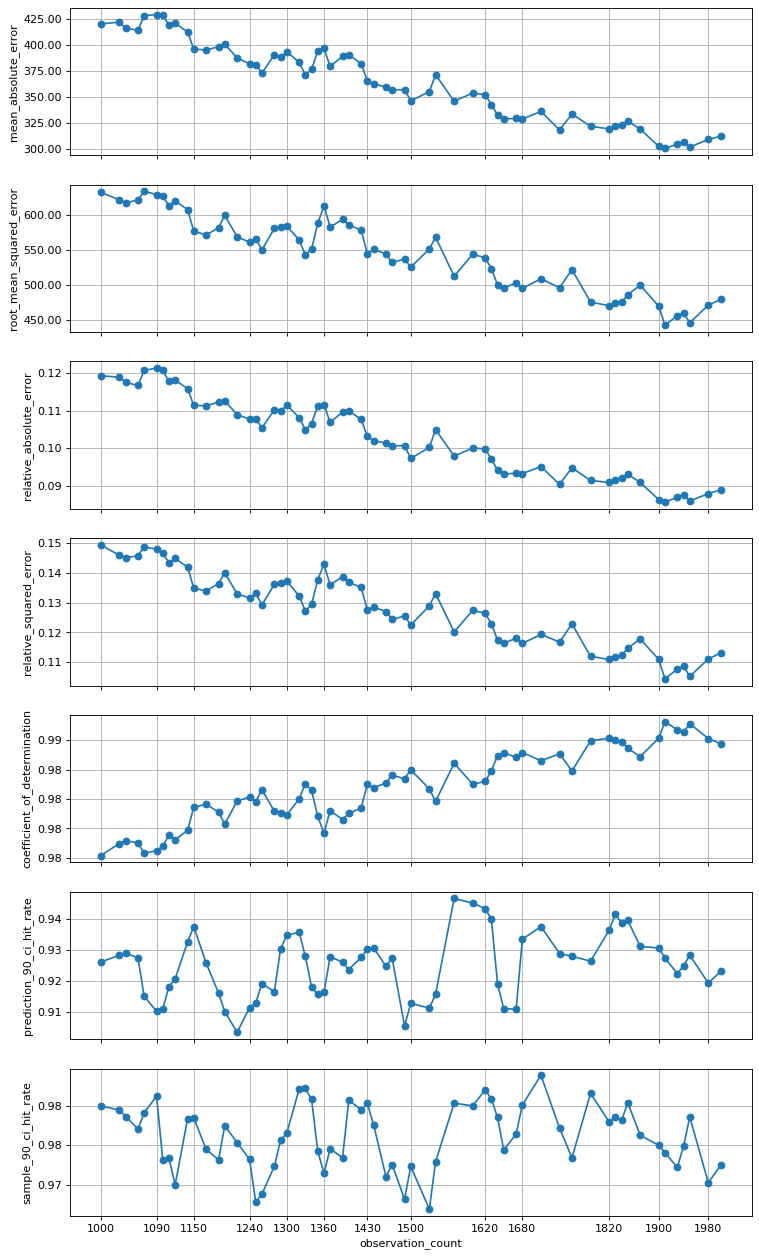

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

gof_df = goodness_of_fit_dataframe
columns_to_plot = [name for name in gof_df.columns.values if name not in ('observation_count', 'prediction_count')]
num_plots = len(columns_to_plot)
fig, axs = plt.subplots(num_plots, figsize=(11, 20), dpi=80, sharex=True)

for i, column in enumerate(columns_to_plot):
    axs[i].plot(gof_df.index, gof_df[column], marker='o', label=column)
    axs[i].set_ylabel(column)
    axs[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    axs[i].set_xticks(gof_df.index[::5])
    axs[i].grid(True)
    if i == num_plots - 1:
        axs[i].set_xlabel('observation_count')
        
fig.show()

## TODO: Bayesian Optimizer Evaluation

1. Perform optimizer convergence evaluation on some functions out of the factory:
    1. Define some named configurations for the BayesianOptimizer (surrogate model config, utility function, utility function optimizer config).
    2. Write the optimum object to:
        1. Include all observations (at first - once we know what we don't need, we can remove them)
        2. Include surrogate model predictions for all observations.
        3. Include a dataframe with the various definitions of optimum:
            1. Best observed observation.
            2. Observation with the highest:
                1. predicted mean
                2. upper confidence bound
                3. lower confidence bound
            3. Speculative optima - kick of the utility function optimizer to find configurations with:
                1. maximum predicted mean
                2. maximum upper confidence bound
                3. maximum lower confidence bound
        1. Include a dataframe with cummax of all of the 7 optima.
        2. Compare the number of iterations needed to reach the same optimum for the various optimizers.
        
    3. Train the various models on the various functions and plot all 7 optima as a function of a number of observations (repeat each experiment a few times to get the idea of stability).
    4. Progressively increase the difficulty of the optimization problems:
        1. Amount of noise.
        2. Number of dimensions.
        3. Discontinuous functions.
        4. Search spaces with more branching and nesting.
        

## TODO: Utility Function Optimizer Evaluation

This is a two-step process.
1. Evaluate these model-free optimizers on the ObjectiveFunctionBase subclasses. This should allow us to capture any bugs, and get a sense of how quickly these optimizers converge on a variety of functions.
2. Evaluate these model-free optimizers as part of the bayesian optimizer. The key difference is that the model gets refit, so the underlying function changes between optimizer invocations, but we get to use prior invocations as starting points.

3. Plot all of this :)